## Model Explainablity

The role of humans in AI is often overlooked compared to the race to develop novel algorithms followed by data augmentation/enhancement techniques. Considering the CRISP-DM cycle once again, we can identify three steps where human interaction is fundamentally important:

    1. Data Understanding: here ML experts extract information from domain SMEs to guide model development. Human input is fundamentally important to shaping feature engineering decisions, model training metrics and model selection.
    
    2. Model Evaluation: determining the best model goes beyond picking the model with the highest performing metric. Beyond considering a suite of metrics, reasoning behind model decision making is important to determing the best model. For instance, we may get the correct answer, but for the wrong reasoning, which can indicate an artifact in the training data and result in poor performance during deployment.
    
    3. Deployment: the purpose of many AI systems in to assist human decision makers. Thus, these systems must provide information humans can and will interact with. 

Explainable AI (XAI) is a field of artificial intelligence comprised of techniques and efforts to explain the predictions made by models. These vary from simplistc approaches, such as permutation feature importance, to more sophisticated approaches such as SHapley Additive exPlanation (SHAP) Values and Local Interpretable Model-agnostic Explanations (LIME). This is a burgeoning field, critical to building trust in AI systems. Though still sometimes perceived as "black boxes", XAI techniques provide for explanations of what features are important in an individual decision. 

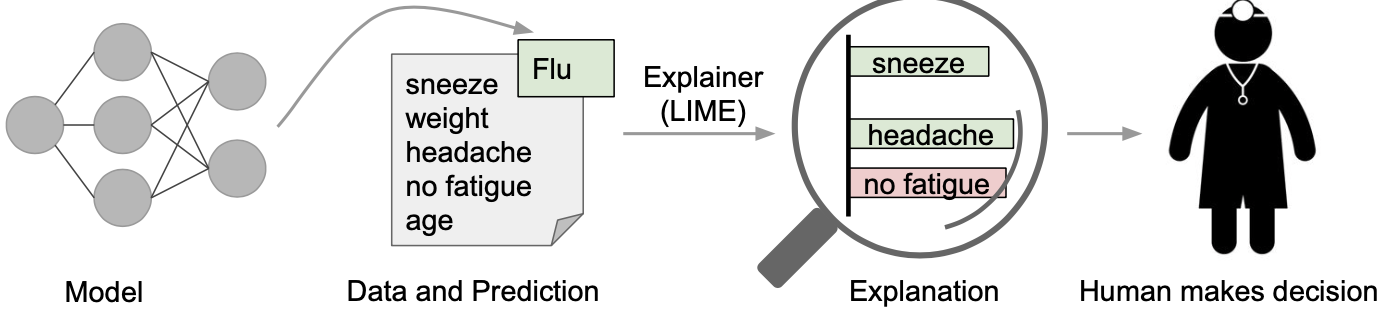

In [12]:
RootDir = '/Users/ggray15/src/python/repos/jhach_cpdsam_symposium_workshop'
os.chdir(RootDir)

In [13]:
# Load in the test set

test_impute = pd.read_csv('data/test_impute.csv')
test_features = test_impute.columns[1:]
target_feature = 'readmit_flag'

# Get X/y
X_test = test_impute[test_features]
y_test = test_impute[target_feature]

In [14]:
# Load in the model 
iKey = 'gb'
filename = 'data/best_model_'+iKey+'.sav'
model = joblib.load(filename)

### Permutation Feature Importance

One of the simplest approaches to determining the importance of features is to permute the values in a feature randomly and measure the effect on the model performance. This approach, aptly labeled permutation feature importance, randomly shuffles (permutes) the values in each column while keeping the other column values fixed. The effect on the evaluation metric is then measured and the delta between the unperturbed metric and the permuted metric is taken as a measure of the importance of the feature. Often, permutations are done many times to account for the randomness of the permutation. This has several significant disadvantages. Firstly is the lack of local explainability, i.e. the importance of features for individual data point cannot be ascertained. Secondly, negative values do not measure the impact of the feature on the class, only on the metric. Thirdly, there is no way to determine the impact of the feature magnitude on the outcome. 

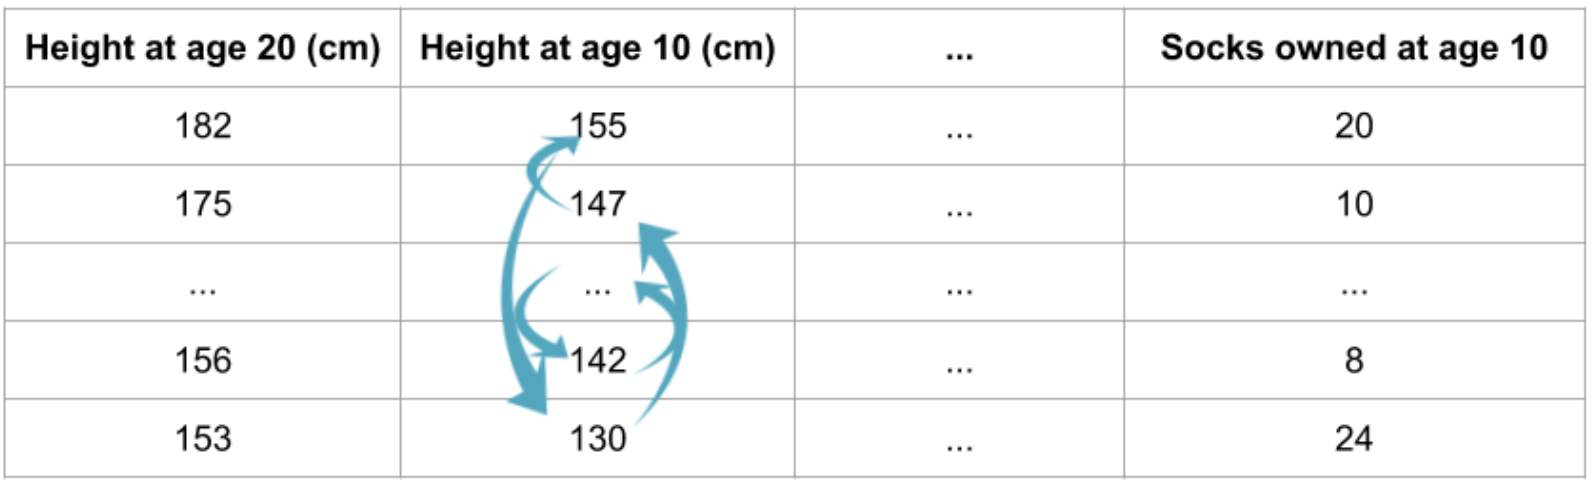

For more information see https://scikit-learn.org/stable/modules/permutation_importance.html#outline-of-the-permutation-importance-algorithm

In [87]:
r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{test_features[i]:<8} "
          f"{r.importances_mean[i]:.3f}"
          f" +/- {r.importances_std[i]:.3f}")

los_scaled 0.123 +/- 0.027
abnormal_lab_fraction 0.080 +/- 0.024
icd9_code_V053 0.027 +/- 0.009
icd9_code_769 0.017 +/- 0.011
icd9_code_7742 0.015 +/- 0.013
micro_organism 0.009 +/- 0.005
admission_type_encode 0.000 +/- 0.001
total_dx_minmax 0.000 +/- 0.000
total_rx_minmax 0.000 +/- 0.000
diagnosis_encode -0.000 +/- 0.001
insurance_encode -0.003 +/- 0.005
icd9_code_V290 -0.008 +/- 0.010
ethnicity_encode -0.012 +/- 0.009


### SHAP Values

SHapley Additive exPlanations represent a more sophisticated approach to XAI than the previously described permutation feature importance. The basic premise originated from Game Theory and was introduced by Lloyd Shapley in 1951 with the intent to measure the impact a player on a team had to the outcome. For XAI, we can treat the features as players and the model prediction as the score of the game. To assess the impact a feature has on the prediction, we can "remove" all other features and assess the model predictions as related to changes in a single feature. Doing this for all N features results in the impact of each feature on the model prediction. However, naively ignores higher order effects (i.e. how do these features interact). To solve this predicament, we can then consider all cominations from 1 - N-1 to fully account for all possible effects of a feature. As an example below, consider a model that attempts to predict salary using Age, Gender and Job (see below).

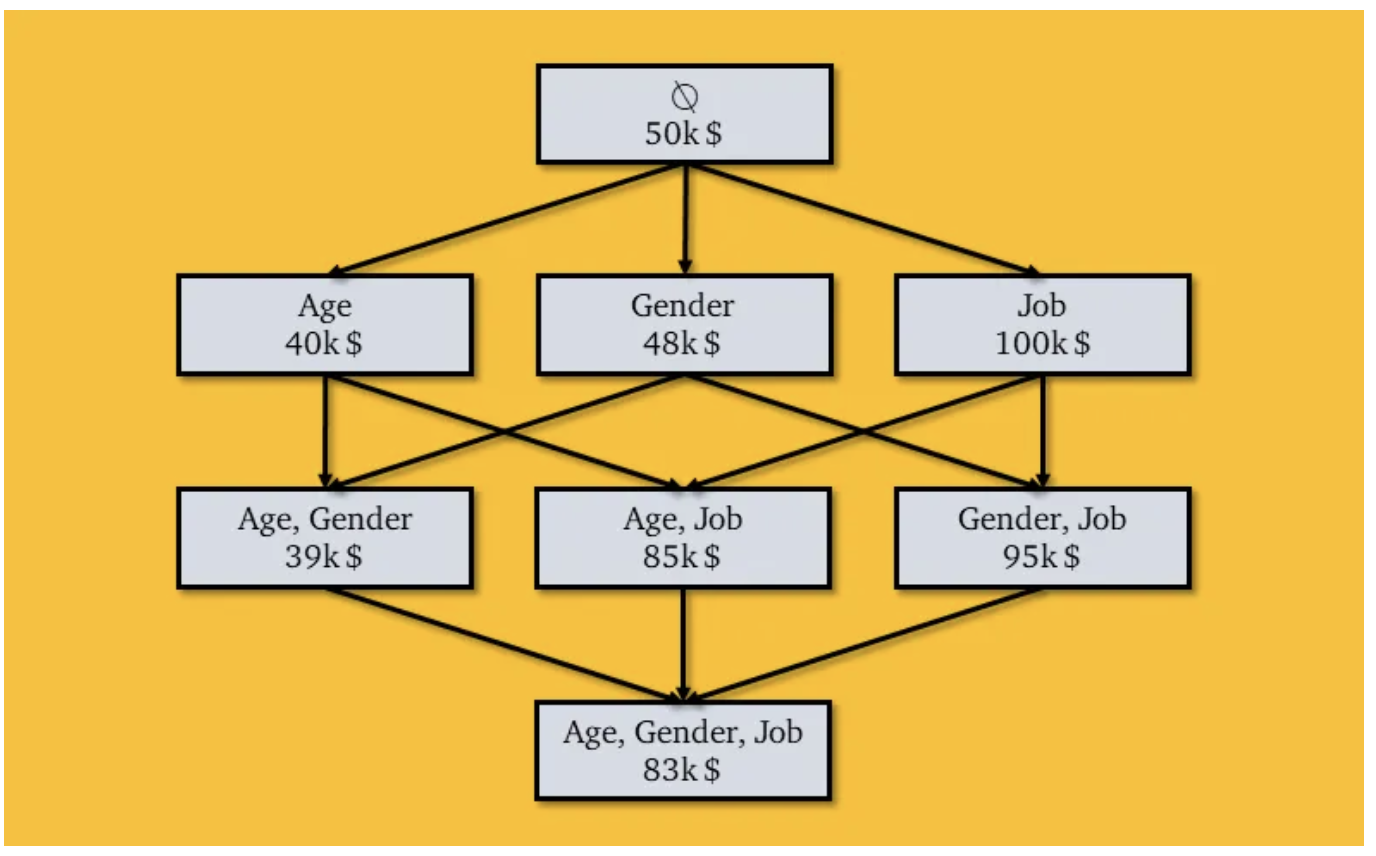

For more informaiton see https://shap.readthedocs.io/en/latest/

In [89]:
shap_explainer = shap.Explainer(model.best_estimator_)
shap_values = shap_explainer.shap_values(X_test)

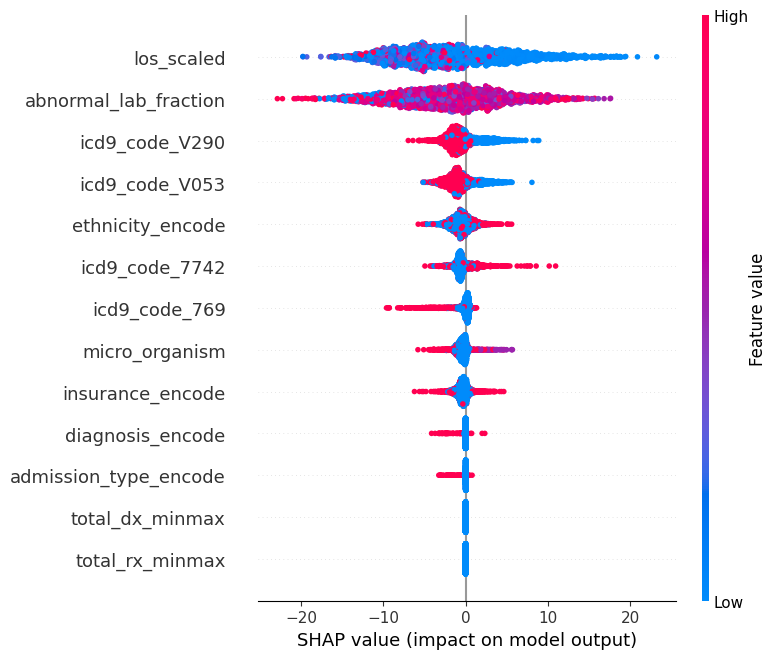

In [90]:
shap.summary_plot(shap_values, X_test)

In [111]:
#shap.plots.waterfall(shap.Explanation(shap_explainer))
shap.Explanation(shap_explainer)

.values =

In [101]:
shap.initjs()
shap.plots.force(shap_explainer.expected_value, shap_values[0])

### LIME

Local Interpretable Model-agnostic Explanations (LIME) assumes that any model can be locally approximated with a linear model. By sampling data points around an input of interest and then fitting a linear learner to that set of data points, a black box model can be locally approxmated with an explainable one. This way, the effects of features on an output can be determined without a need to approximate the entire (much more complex) decision surface. 

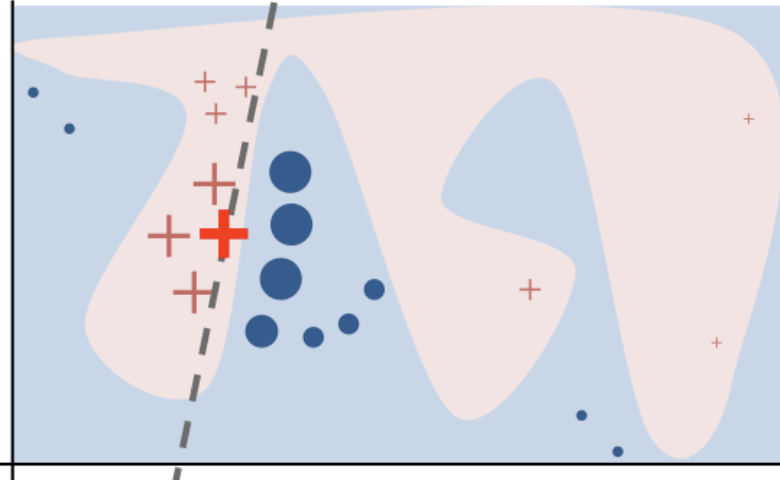

For more information see https://github.com/marcotcr/lime or https://arxiv.org/abs/1602.04938

In [75]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=test_impute.columns.values.tolist(), class_names=['readmit_flag'], discretize_continuous=True)

In [85]:
exp = explainer.explain_instance(X_test.values[5], model.best_estimator_.predict_proba, num_features=13)

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names


In [86]:
exp.show_in_notebook(show_table=True, show_all=False)